## Кейс №2. РЕШЕНИЕ УРАВНЕНИЯ $f(x)=0$

**Моделирование ПИ-регулятора.**

### **0. Постановка задачи**

В данной работе нас интересует управление роботом на прямолинейном участке
движения. Нам необходимо разогнать робота до заранее установленной (круизной)
скорости $v_{dir}$ и поддерживать её. 

---------

Чтобы решить данную задачу, нам придется составить уравнение движения и решить его при использовании автоматизированного управления.


In [29]:
from google.colab import drive
drive.mount('/content/drive')

import sys

sys.path.append("/content/drive/My Drive/Colab Notebooks/Calculations/Case 2.1/")
sys.path.append("/content/drive/My Drive/Colab Notebooks/COMP_MATH/Cases/case-2_1/")

In [30]:
# Импортируем необходимые библиотеки и функции из модулей
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
print('Last Updated On: ', datetime.datetime.now())

# ----------------              Загрузка модулей               -----------------
from utils import drawErrorDynamic, show_convergence_rate_plot #, analys_tdone, calc_opt_regulpars, calc_velocity_dynamics

Last Updated On:  2021-12-06 21:32:28.397308


### **1. Модель движения робота**

Общее уравнение движения робота по прямой выглядит следующим образом:
$$(1) \;  𝑚 ∗ 𝑎 = 𝐹 \  – 𝐹𝑐 $$

или

$$(1') \;  𝑎 = \frac {dv}{dt} = \frac {1}{m} * (𝐹 \  – 𝐹𝑐) $$

Здесь 
$$ 𝐹 =
\left \{
    \begin{aligned}
    𝐹𝑚𝑜𝑡𝑜𝑟 = 𝑢 > 0 \\
    𝐹𝑏𝑟𝑎𝑐𝑘𝑒𝑡 = 𝑢 < 0 \\
	\end{aligned}
\right.
$$

$𝐹$ – сила раскрутки ($𝐹𝑚𝑜𝑡𝑜𝑟$) или торможения ($𝐹𝑏𝑟𝑎𝑐𝑘𝑒𝑡$) колес (Н);

$Fc = kc*v$ – сила сопротивления воздуха движению авто (Н);

$m, v, a$ - масса (кг), скорость (м/с) и ускорение ($м*c^{-2}$) робота соответственно.

--------

Мы должны научиться управлять ускорением и, в конечном счете, скоростью робота. Для этого надо сконструировать алгоритм автоматического расчета силы $F$  в зависимости от текущей скорости.

Также надо учесть, что наши возможности не безграничны и сила должна удовлетворять условию:

$$-Fmax \le F \le Fmax$$

------------


In [31]:
# Для примера расчета установим параметры модели движения робота:
# -----------------------------------------------
robot_m = 100    # масса робота, кг
Fmax = 200  # максимальная сила ускорения-торможения, Н
kc = 2       # коэффициент сопротивления воздуха

model_pars = {'m':robot_m, 'kc':kc, 'Umax':Fmax}

### **2. Модель управления**

Рассмотрим модель управления движением мобильным роботом.

#### **ПИ-регулятор ускорения движения робота**

Данный ПИ-регулятор устанавливает силу ускорения или торможения 
робота $F$ в зависимости от текущей его скорости $v$. Идея проста, чем больше  расхождение между $v_{dir}$ и текущей скоростью $v$, тем должна быть больше сила и ускорение, чтобы это расхождение уменьшить:

$$(ПИ-регулятор) \;
\left\{
   	\begin{aligned}
       \varepsilon_{v}[t] &= v_{dir} - v[t] \\
       F[t] &= kP * \varepsilon_{v}[t] + kI * \int_{t - t_{lag}}^{t} \varepsilon_{v}[\tau]*d\tau
	\end{aligned}
\right.
$$

Здесь 
- $\varepsilon_{v}[t]$ - разница между директивной скоростью $v_{dir}$ и текущей скоростью робота $v[t]$ в момент времени t (м/с);

- $v_{dir}$ - директивная скорость (м/с);

- $v[t]$ - скорость робота в момент времени t (м/с);

- $kP, kI$ - коэффициенты управления пропорционального (П-) и интегрального (И-) регуляторов соответственно (ПИ-регулятор);

- $t_{lag}$ - лаг по времени, за какой интервал времени мы накапливаем (интегрируем ошибку), начиная с текущего момента времени (с).

------------

In [32]:

# устанавливаем параметры ПИ-регулятора:
# -----------------------------------------------
cruize_vel = 25     # директивная круизная скорость, м/с
regulator_kP = 3    # коэффициент пропорционального регулятора
regulator_kI = 0.3  # коэффициент интегрального регулятора
regulator_lag = 400 # с, максимальный лаг по времени при вычислении интегральной ошибки

regul_pars = {'Vdir':cruize_vel, 'kP':regulator_kP, 'kI':regulator_kI, 'lag': regulator_lag}

### **3. Модель расчета динамики изменения скорости.**

Для расчета динамики изменения скорости в зависимости от выбранного управления подставим выбранное нами управление (ПИ-регулятор) в уравнение движения (1) или (1'):

$$(2) \;  \frac {dv}{dt}= \frac {1}{m} * (kP * \varepsilon_{v}[t] + kI * \int_{t - t_{lag}}^{t} \varepsilon_{v}[\tau]*d\tau - kc*v)$$

Будем решать данное дифференциальное уравнение приближенно, заменив непрерывное время на дискретное время с шагом $\Delta t$:

$t_0, t_1 = t_0+\Delta t, t_2 = t_0+2\Delta t, ...$ 

Вместо производной $\frac {dv}{dt}$ подставим ее дискретный аналог, а вместо интеграла приближенную сумму:

$$(3) \;  \frac {v[t_{i+1}] - v[t_i]}{\Delta t}= \frac {1}{m} * (kP * \varepsilon_{v}[t_i] + kI * \sum_{t - t_{lag} \le t[i] \le t}^{} \varepsilon_{v}[t[i]]*\Delta t - kc*v[t[i]])$$

Упростим запись, введя обозначения 

$t_i = t[i]$, 

$v_i = v[t_i]$,

$\varepsilon_i = \varepsilon_{v}[t_i]$.

Получим уравнение

$$(3') \;  \frac {v_{i+1} - v_i}{\Delta t}= \frac {1}{m} * (kP * \varepsilon_i + kI * \sum_{i - n_{lag} \le j \le i}^{} \varepsilon_j*\Delta t - kc*v_i),$$

которое легко преобразовать в итерационный процесс:

$$(4) \;  v_{i+1} = v_i + \frac {\Delta t}{m} * (kP * \varepsilon_i + kI * \sum_{i - n_{lag} + 1 \le j \le i}^{} \varepsilon_j*\Delta t - kc*v_i), i=0,1,...,$$

задав начальную скорость и все остальные параметры модели и управления.

Здесь 

$n_{lag}$ - это количество шагов дискретного времени за интервал $t_{lag}$.

------------

Имея такой итерационный процесс $x = x - \alpha *f(x)$, легко догадаться, что мы решаем уравнение вида:

$$kP * \varepsilon_{v}[t] + kI * \int_{t - t_{lag}}^{t} \varepsilon_{v}[\tau]*d\tau - kc*v[t] = 0,$$

или 

$$ F(t) = F_c(t) .$$

---------


In [33]:
# параметры расчета динамики изменения скорости
# -----------------------------------------------------------------
v0 = 0   #Начальная скорость
t0 = 0   # время старта
tmax = 400   # максимальное время расчета
dt = 1   # временной шаг расчета / дискретизации
v_precision = 0.1  #Точность достижения круизной скорости

calc_pars = {'v0':v0, 't0':t0, 'tmax':tmax, 'dt':dt, 'v_precision':v_precision}

### **4. Алгоритм расчета динамики изменения скорости движения объекта с заданными параметрами управления**

**ВХОД**: calc_pars, model_pars, regul_pars

**ВЫХОД**: v_trace = np.array() - трассировка скорости во все моменты расчета, начиная с момента времени t0 и до момента времени tmax с шагом dt, n величин, в n моментов времени $t0, t0+dt, t0+2dt, ... (int(tmax / dt))*dt.$ 

v_trace.shape = (2, nsteps+1), nsteps = $int((tmax - t0) / dt), nlag = int(lag / dt)$

v_trace[0] - содержит все расчетные моменты времени в возрастающем порядке,

v_trace[1] - содержит скорости в соответствующие моменты времени.

------------

Алгоритм расчета:
0. Инициализируем $v\_trace = [v0]$; $err = []$

1. $for \  step \  in \  range(nsteps):$

  1.1. рассчитываем ошибку управления:
  $err[step] = Vdir - v\_trace[step]$ \\
  1.2. рассчитываем интегральную ошибку за интервал времени $lag$ (до текущего момента):
  $sumerr[step] = \sum_{i \in [step-n(lag), step]} {err[i]}$ \\
  1.3. рассчитываем пропорциональную составляющую управления: $uP = kP*err[step]$ \\
  1.4. рассчитываем интегральную составляющую управления: $uI = kI*sumerr[step]*dt$ \\
  1.5. рассчитываем суммарное управляющее воздействие: $F = uP + uI$ \\
  1.6. корректируем управление так, чтобы соблюдалось условие $-Fmax \le F \le Fmax$ \\
  1.7. Применяем управление: \\
  $dV = (F - kc*v[step])*dt / m$ \\
  $v[step+1] = v[step] + dV$ \\
  1.8. дополняем $v\_trace$

2. Выход с $v\_trace$

In [34]:
# ---------------------- ВАШ КОД ------------------------
def calc_velocity_dynamics(calc_pars, model_pars, regul_pars):
    Vcur = calc_pars['v0']
    v_trace = [np.array([calc_pars['t0'], Vcur])]
    errors = []
    # ------- здесь ваш код --------
    nsteps = round((calc_pars['tmax'] - calc_pars['t0']) / calc_pars['dt'])
    nlag = round(regul_pars['lag'] / calc_pars['dt'])
    t = calc_pars['t0']
    for step in range(nsteps):
        # 1. Рассчитаем текущую ошибку управления
        error = regul_pars['Vdir'] - Vcur
        errors.append(error)

        # 2. Рассчитаем суммарную ошибку за nlag последних шагов
        sumerror = sum(errors[-nlag:])

        # 3. рассчитываем пропорциональную составляющую управления
        uP = regul_pars['kP'] * error

        # 4. рассчитываем интегральную составляющую управления
        uI = regul_pars['kI'] * sumerror * calc_pars['dt']

        # 5. рассчитываем суммарное управляющее воздействие
        F = uP + uI

        # 6. корректируем управление так, чтобы соблюдалось условие  −Fmax≤F≤Fmax
        if F < -model_pars['Umax']:
            F = -model_pars['Umax']
        if F > model_pars['Umax']:
            F = model_pars['Umax']

        # 7. расчет изменения скорости за шаг времени dt
        dV = (F - model_pars['kc'] * Vcur) * calc_pars['dt'] / model_pars['m']

        # 8. Расчет скорости в следующий момент времени
        Vcur += dV
        t += calc_pars['dt']

        v_trace.append(np.array([t, Vcur]))

    return np.array(v_trace).T

### **5. Пример расчета №1: $dt=1 (c)$**

In [35]:
# произведём расчет траектории и выведем результат расчета:
v_trace = calc_velocity_dynamics(calc_pars, model_pars, regul_pars)

In [36]:
print(v_trace.shape)
print(v_trace[:,0:10])
print(v_trace[:,201:209])

(2, 401)
[[0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   ]
 [0.    0.825 1.681 2.565 3.471 4.397 5.338 6.292 7.253 8.22 ]]
[[201.    202.    203.    204.    205.    206.    207.    208.   ]
 [ 25.12   25.113  25.106  25.099  25.092  25.085  25.078  25.071]]


#### **5.2. Результат расчета №1**

v_trace.shape = (2, 401)

v_trace = 
[[0.    0.   ]

 [1.    0.825]

 [2.    1.681]

 [3.    2.565]

 [4.    3.471]

 [5.    4.397]]

...

[[201.     25.12 ]
 [202.     25.113]
 [203.     25.106]
 [204.     25.099]
 [205.     25.092]
 [206.     25.085]
 [207.     25.078]
 [208.     25.071]]

#### **5.3. Визуализация динамики скорости для заданного ПИ-регулятора**

In [37]:
def drawDynamic(V_trace, Pars):
    Vdir = Pars['Vdir']
    if 'Tdone' in Pars:
        Tdone = Pars['Tdone']
    else:
        Tdone = -1

    fig = plt.figure(figsize=(8, 7))
    plt.plot(V_trace[0], V_trace[1], 'c', label='скорость робота')
    plt.plot([V_trace[0][0], V_trace[0][-1]], [Vdir, Vdir], 'r--', label='цель')
    plt.xlabel('t, сек')
    plt.ylabel('V, м/с')
    minV = min(V_trace[1]); maxV = max(V_trace[1])
    if Tdone > 0:
        plt.plot([Tdone, Tdone], [minV, maxV], 'y--', label='время достижения цели={:05.1f}'.format(Tdone))
    plt.legend(loc=4, fontsize=12)
    plt.title('Динамика скорости (м/с)')
    plt.show()


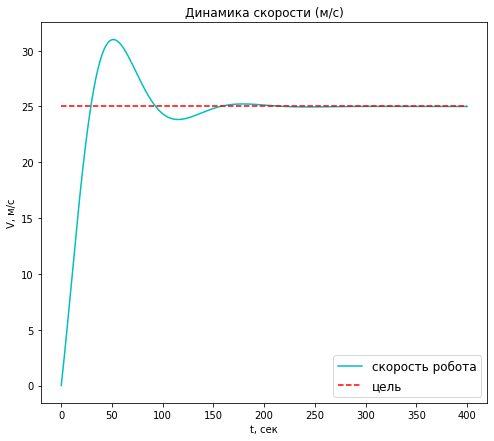

In [38]:
# отрисовываем динамику скоростей и управляющих воздействий
drawDynamic(v_trace, {'Vdir':cruize_vel})

In [39]:
def analys_tdone(v_trace, cruize_vel, v_precision):
    fluctuations = []
    for t, v in v_trace.T:
        fluctuations.append((t, np.abs(cruize_vel - v) < v_precision))

    tdone = 0
    for i in reversed(range(len(fluctuations))):
        if not fluctuations[i][1]:
            tdone = fluctuations[i + 1][0]
            break

    return tdone

-----------

#### **5.4. Анализ времени достижения круизной скорости с заданной точностью**


In [40]:
t_done = analys_tdone(v_trace, cruize_vel, v_precision)
print('время достижения заданной точности', t_done)
print(analys_tdone2(v_trace, cruize_vel, v_precision))

время достижения заданной точности 204.0


NameError: name 'analys_tdone2' is not defined

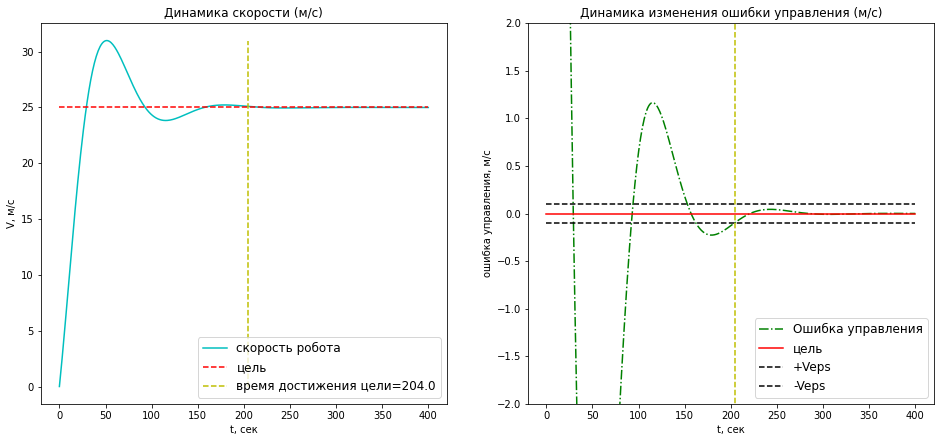

In [42]:
# иллюстрация достижения точности
drawErrorDynamic(v_trace, {'Vdir':cruize_vel, 'Tdone':t_done})

**ВЫВОД**. При заданных значениях параметров регулятора kP=3, kI=0.3 и dt=1c мы добиваемся заданной точности за 204 сек. Но видим, что были достаточно большие колебания скорости. Поэтому качество управления можно улучшить.

----------


### **6. Пример расчета №2: $dt=0.5 (c)$**

Все параметры оставим без изменения. Изменим только шаг по времени и посмотрим как отразится на динамике изменения скорости и времени достижения круизной скорости.

---------


In [ ]:
# параметры расчета динамики изменения скорости
# -----------------------------------------------------------------
v0 = 0   #Начальная скорость
t0 = 0   # время старта
tmax = 400   # максимальное время расчета
dt = 0.5   # временной шаг расчета / дискретизации
v_precision = 0.1  #Точность достижения круизной скорости

calc_pars = {'v0':v0, 't0':t0, 'tmax':tmax, 'dt':dt, 'v_precision':v_precision}

In [45]:
# произведём расчет траектории и выведем результат расчета:
v_trace = calc_velocity_dynamics(calc_pars, model_pars, regul_pars)

In [48]:
# выведем размеры массива и несколько точек траектории для контроля алгоритма
print(v_trace.shape)
print(v_trace.T[0:5,:])
print(v_trace.T[410:415,:])

(2, 401)
[[0.    0.   ]
 [1.    0.825]
 [2.    1.681]
 [3.    2.565]
 [4.    3.471]]
[]


#### **6.2. Результат расчета №2**

v_trace.shape = (2, 801)

v_trace = 

[[0.    0.   ]

 [0.5   0.394]

 [1.    0.796]

 [1.5   1.207]

 [2.    1.625]]
 ...

[[205.     25.104]
 [205.5    25.101]
 [206.     25.097]
 [206.5    25.094]
 [207.     25.09 ]]

#### **6.3. Визуализация динамики скорости для заданного ПИ-регулятора**


In [ ]:
# отрисовываем динамику скоростей и управляющих воздействий
drawDynamic(v_trace, {'Vdir':cruize_vel})

#### **6.4. Анализ времени достижения круизной скорости с заданной точностью**


In [ ]:
t_done = analys_tdone(v_trace, cruize_vel, v_precision)
print('время достижения заданной точности', t_done)
print(analys_tdone2(v_trace, cruize_vel, v_precision))

In [ ]:
# иллюстрация достижения точности
drawErrorDynamic(v_trace, {'Vdir':cruize_vel, 'Tdone':t_done})

**ВЫВОД**. При заданных значениях параметров регулятора kP=3, kI=0.3 и dt=0.5c мы добиваемся заданной точности за 206,5 сек. Это чуть больше, чем при дискретности управления dt=1c. Связано с более мягким набором скорости за счет того, что интеграл теперь более точно аппроксимируется суммой.

---------


### **7. Поиск оптимальных значений параметров управления**

Проведем поиск оптимальных значений параметров управления при неизменных остальных значениях параметров модели движения и расчета.

In [ ]:
# производим поиск оптимальных значений параметров
opt_kP, opt_kI, opt_lag, min_tdone = calc_opt_regulpars(calc_pars, model_pars, cruize_vel)
print('найдены оптимальные параметры управления:')
print('opt_kP=', round(opt_kP, 2))
print('opt_kI=', round(opt_kI, 2))
print('opt_lag=', opt_lag)

In [ ]:
# производим расчет траектории при оптимальных значениях параметров
regul_pars['kP'] = opt_kP
regul_pars['kI'] = opt_kI
regul_pars['lag'] = opt_lag
v_trace = calc_velocity_dynamics(calc_pars, model_pars, regul_pars)

In [ ]:
# выведем размеры массива и несколько точек траектории для контроля алгоритма
print(v_trace.shape)
print(v_trace.T[0:9,:])
print(v_trace.T[355:364,:])

In [ ]:
t_done = analys_tdone(v_trace, cruize_vel, v_precision)
print('время достижения заданной точности', t_done)
drawErrorDynamic(v_trace, {'Vdir':cruize_vel, 'Tdone':t_done})

### Оценка скорости сходимости при оптимальных значениях параметров управления 

In [ ]:
# -------------------------------------------------------------------------------------------------
# ---------  функция расчета динамики погрешности eps[n] = cruize_vel - Vn > Veps  ---------
# V_trace[0] - последовательность шагов времени, V_trace[0] - последовательность скоростей,
# cruize_vel - заданная круизная скорость, Veps - аналитический допуск приближения к директивной скорости
# ----------------------------------------------------------------------------------------------------
def calc_errors(v_trace, cruize_vel, Veps):
    Vn = v_trace[1]; tn = v_trace[0]
    u = (cruize_vel - Vn) < Veps
    tic_max = min(min(tn[u])-1, tn[-1])
    u1 = tn <= tic_max 
    eps =  cruize_vel - Vn[u1]
    return eps

# ----------------------------------------------------------------------------------------------------
# -------------     функция расчета последовательности cn = eps[n+1]/eps[n]**p  ----------------
# eps - динамикf погрешности eps[n] = cruize_vel - Vn,   p - предполагаемый порядок сходимости
# ----------------------------------------------------------------------------------------------------
def calc_relative_errors(eps, p):
    cc = eps[1:] / eps[:-1]**p
    return cc

In [ ]:
eps = calc_errors(v_trace, cruize_vel, Veps=5)
cc = calc_relative_errors(eps, p=1.03)
show_convergence_rate_plot(cc)

In [ ]:
cc = calc_relative_errors(eps, p=1.02)
show_convergence_rate_plot(cc)
